In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import v2
from torchvision.transforms.functional import adjust_contrast
import matplotlib.pyplot as plt
import random
import glob

from einops import rearrange, repeat

/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/jakwisn/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please sub

In [3]:
from dataset import *

SEED = 8
DATASET_SIZE = 40000

def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    
set_seed()

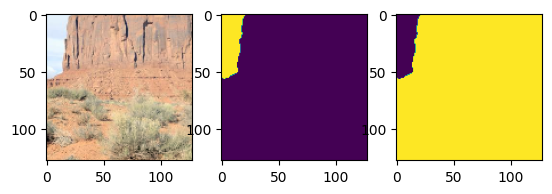

In [38]:
transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(256),
    # v2.RandomCrop(size=(128, 128)) # We dont do mask transformation 
    ])

input_images = glob.glob('data/training/INPUT_IMAGES/*P1.5.JPG')[:100]
val_images = glob.glob('data/validation/GT_IMAGES/*.jpg')[:6]

train_dataset = CorrectionImageDataset(input_images, train=False, transform=transform)
validation_dataset = CorrectionImageDataset('data/validation/GT_IMAGES', train=False, transform=transform)

# test set must be done with the same data 
im, mask = train_dataset[0]

fig, axs = plt.subplots(1,3)
axs[0].imshow(im.permute((1,2,0)))
axs[1].imshow(mask) # Unknown region to generate
axs[2].imshow(~mask) # Known region

In [39]:
len(train_dataset)

100

In [40]:
len(validation_dataset)

25

# Training the model

In [41]:
from ddpm.ddpm import *
from ddpm.ddpm_train import *

BATCH_SIZE=6
RESIZE_SIZE = 64
IM_SIZE=64


transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    v2.Resize(size=(RESIZE_SIZE, RESIZE_SIZE)),
    #v2.RandomCrop(size=(IM_SIZE, IM_SIZE))
    ])

In [42]:
train_dataset = CorrectionImageDataset(input_images, train=True, transform=transform)
val_dataset = CorrectionImageDataset(val_images, train=False, transform=transform)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else None)  
print(f"Model will run on {device}")

dataloader = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=6, 
                        persistent_workers=True,
                        pin_memory=True)

valdataloader = DataLoader(val_dataset,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           persistent_workers=True,
                           num_workers=6,
                           pin_memory=True)

train(dataloader, valdataloader, device=device, T=250, img_size=IM_SIZE, channels=64, batch_size=BATCH_SIZE, experiment_name='pretrained')

Model will run on cuda


12:05:45 - INFO: Starting epoch 1:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]
12:11:41 - INFO: Sampling 6 new images....
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [1:03:23<00:00, 15.28s/it]
01:15:11 - INFO: Starting epoch 2:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.23it/s]
01:23:11 - INFO: Sampling 6 new images....
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 249/249 [37:40<00:00,  9.08s/it]
02:00:55 - INFO: Starting epoch 3:
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]
02:06:57 - INFO: Sampling 6 new images....
  8%|█

In [ ]:
sdadas

In [ ]:
(~m.unsqueeze(1)).shape

In [ ]:
x_known = x * ~m.unsqueeze(1)
x_unknown = x * m.unsqueeze(1)

In [ ]:
img_known = np.einsum('xabc->bca', x_known)

In [ ]:
x.shape

In [ ]:
plt.imshow(np.einsum('abc->bca', x_unknown[1]))

In [ ]:
plt.imshow( np.einsum('abc->bca', x_known[1]))

# algo: 
## q-sample
* we do it normally, for full image
* after everything we apply masks to each of the noised image

## p sample 
* we take noised image and denoise it
* we apply masks and get values only for the maksed regions
* we then add corresponding noised image from the q sample with masks 

In [ ]:
set_seed(SEED)
im, mask = train_dataset[0]


# Apply the mask to all three channels of the image
result = im * mask.unsqueeze(0)
print(result[0,0,0])
plt.imshow(result.permute(1,2,0))
plt.show()